https://www.datacamp.com/community/tutorials/xgboost-in-python

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + 'D:/LatexPackage/miktex/bin/x64'

In [2]:
os.environ["PATH"] += os.pathsep + 'D:/Database/Bitfinex-historical-data-master/Bitfinex-historical-data-master'

In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
from sklearn.datasets import load_boston

In [5]:
from pandas.plotting import scatter_matrix

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
import pylab

In [8]:
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt

from datetime import datetime

import pandas as pd
import urllib.request
     

from IPython.display import clear_output

In [9]:
import seaborn as sns

In [10]:
## Loading BTC and XRP Data

In [11]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [12]:
BTC_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\BTCUSD\Candles_1m'

In [13]:
BTC_2019 = pd.read_csv(BTC_USD_1min_path + '/2019/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [14]:
BTC_2018 = pd.read_csv(BTC_USD_1min_path + '/2018/merged.csv', header=None ,names =  ['btc_' + d for d in header_format])

In [15]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [16]:
XRP_2018 = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None, names = ['xrp_' + d for d in header_format])

In [17]:
XRP_2019 = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None , names =  ['xrp_' + d for d in header_format])

In [18]:
btc_xrp_merged_2019 = BTC_2019.merge(XRP_2019, 
               left_on = 'btc_timestamp_UTC_millisec', 
               right_on = 'xrp_timestamp_UTC_millisec', 
               how = 'outer')

In [19]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['xrp_timestamp_UTC_millisec']

In [20]:
btc_xrp_merged_2019['time_stamp_UTC_millisec'] = btc_xrp_merged_2019['time_stamp_UTC_millisec'].fillna(btc_xrp_merged_2019['btc_timestamp_UTC_millisec'])

In [21]:
btc_xrp_merged_2019.tail()

,btc_timestamp_UTC_millisec,btc_open_price,btc_close_price,btc_highest_price,btc_lowest_price,btc_volume,xrp_timestamp_UTC_millisec,xrp_open_price,xrp_close_price,xrp_highest_price,xrp_lowest_price,xrp_volume,time_stamp_UTC_millisec
435091,NaN,NaN,NaN,NaN,NaN,NaN,1.572598e+12,0.29248,0.29254,0.29254,0.29243,35279.507174,1.572598e+12
435092,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29166,0.29165,0.29166,0.29165,388.265000,1.572601e+12
435093,NaN,NaN,NaN,NaN,NaN,NaN,1.572601e+12,0.29189,0.29189,0.29189,0.29183,2000.000000,1.572601e+12
435094,NaN,NaN,NaN,NaN,NaN,NaN,1.572603e+12,0.29201,0.29201,0.29201,0.29201,100.000000,1.572603e+12
435095,NaN,NaN,NaN,NaN,NaN,NaN,1.572605e+12,0.29211,0.29211,0.29211,0.29211,834.642329,1.572605e+12


# Starting of analysis

### Get 1min XRP data

In [22]:
XRP_USD_1min_path = 'D:\Database\Bitfinex-historical-data-master_backup\Bitfinex-historical-data-master\XRPUSD\Candles_1m'

In [23]:
header_format = ['timestamp_UTC_millisec',
'open_price',
'close_price',
'highest_price',
'lowest_price',
'volume']

In [24]:
xrp_2018_full = pd.read_csv(XRP_USD_1min_path + '/2018/merged.csv', header=None)

In [25]:
xrp_2019_until_Oct = pd.read_csv(XRP_USD_1min_path + '/2019/merged.csv', header=None)

In [26]:
xrp_2018_full.columns = header_format

In [27]:
xrp_2019_until_Oct.columns = header_format

In [28]:
xrp_2018_onwards = pd.concat([xrp_2018_full, xrp_2019_until_Oct])

In [29]:
XRP_Data = xrp_2018_onwards[xrp_2018_onwards['timestamp_UTC_millisec'] >= 1534287600000]

In [30]:
XRP_Data['datetime_real'] = XRP_Data['timestamp_UTC_millisec'].apply(lambda x: datetime.utcfromtimestamp(x/1000))

In [31]:
len(XRP_Data)

564561

In [32]:
XRP_Data['datetime_real'].min()

Timestamp('2018-08-14 23:00:00')

In [33]:
XRP_Data['datetime_real'].max()

Timestamp('2019-11-01 15:59:00')

In [34]:
(XRP_Data['datetime_real'].max() - XRP_Data['datetime_real'].min())

Timedelta('443 days 16:59:00')

In [35]:
XRP_Data['checking_timestamp_UTC_millisec'] = XRP_Data['timestamp_UTC_millisec'].shift(-1)

In [36]:
XRP_Data['dif'] = XRP_Data['checking_timestamp_UTC_millisec'] - XRP_Data['timestamp_UTC_millisec']

In [37]:
XRP_Data_resample_1min_ffill = XRP_Data.set_index('datetime_real').resample('1T').ffill()

In [38]:
XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec'].shift(-1)

In [39]:
XRP_Data_resample_1min_ffill['dif'] = XRP_Data_resample_1min_ffill['checking_timestamp_UTC_millisec'] - XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']

In [40]:
XRP_Data_resample_1min_ffill['timestamp_UTC'] = XRP_Data_resample_1min_ffill['timestamp_UTC_millisec']/1000

In [41]:
XRP_Data_resample_1min_ffill.head()

,timestamp_UTC_millisec,open_price,close_price,highest_price,lowest_price,volume,checking_timestamp_UTC_millisec,dif,timestamp_UTC
datetime_real,,,,,,,,,
2018-08-14 23:00:00,1534287600000,0.26444,0.26427,0.26448,0.26427,21493.134691,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:01:00,1534287660000,0.26410,0.26408,0.26418,0.26408,6316.950507,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:02:00,1534287720000,0.26419,0.26429,0.26429,0.26390,15876.859198,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:03:00,1534287780000,0.26389,0.26359,0.26389,0.26359,15102.000000,1.534288e+12,60000.0,1.534288e+09
2018-08-14 23:04:00,1534287840000,0.26368,0.26359,0.26379,0.26359,6305.473357,1.534288e+12,60000.0,1.534288e+09


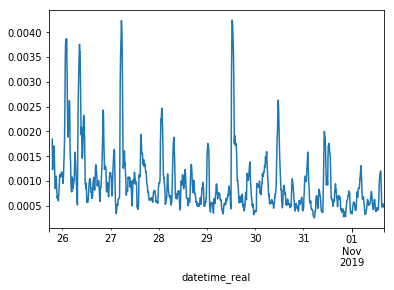

In [46]:
XRP_Data_resample_1min_ffill[-10000:]['close_price'].rolling(100).std().plot()

In [49]:
XRP_5min = XRP_Data_resample_1min_ffill.reset_index()

In [54]:
XRP_5min = XRP_5min.groupby(pd.Grouper(key='datetime_real', freq= '5min')).agg({'close_price':'mean'})

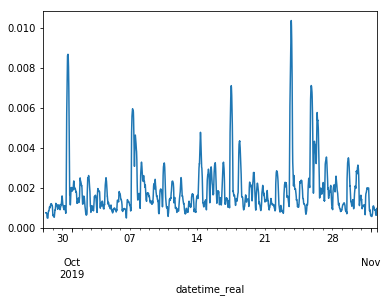

In [57]:
XRP_5min[-10000:]['close_price'].rolling(100).std().plot()

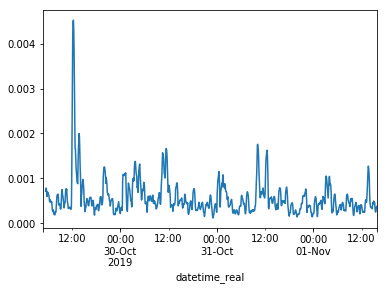

In [60]:
XRP_5min[-1000:]['close_price'].rolling(10).std().plot()

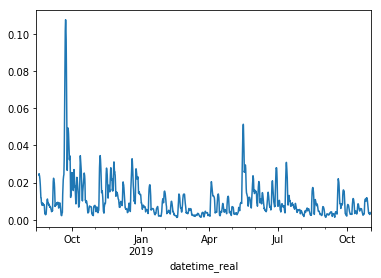

In [62]:
XRP_5min[-200000:]['close_price'].rolling(1000).std().plot()